<a href="https://colab.research.google.com/github/zmunilla/TFM/blob/main/5_Siamese_Contrastive_PEC4_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CONECTAMOS A DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**CARGAMOS LIBRERÍAS**

In [ ]:
import os
import shutil
import random
from pathlib import Path
from math import floor
from PIL import Image
from torch.utils.data import Dataset
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
import pickle
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder
from collections import defaultdict
from tqdm import tqdm

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

**FUNCIONES DE TRANSFORMACIÓN**

In [ ]:
# REDIMENSIONAR SIN DEFORMAR

from torchvision.transforms import functional as TF

class ResizeWithPadding:
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        target_h, target_w = self.size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)

        img = TF.resize(img, (new_h, new_w))

        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        pad_right = target_w - new_w - pad_left
        pad_bottom = target_h - new_h - pad_top

        img = TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img

#los bordes de las imágenes que hay que rellenar para completar el tamaño se rellenan
#con color negro

**FUNCION CREAR PARES AL VUELO CON 30% POSITIVOS Y 70% NEGATIVOS Y AUMENTACIÓN DE DATOS EN CONJUNTO DE ENTRENAMIENTO**

In [ ]:
#AUMENTACIÓN DE DATOS EN CONJUNTO DE ENTRENAMIENTO

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import random
from torchvision.transforms import functional as TF

# Redimensionado sin deformar

class ResizeWithPadding:
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        target_h, target_w = self.size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)
        img = TF.resize(img, (new_h, new_w))

        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        pad_right = target_w - new_w - pad_left
        pad_bottom = target_h - new_h - pad_top

        img = TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img

# Dataset siamesa

class SiameseDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_images = {
            cls: [os.path.join(root_dir, cls, f)
                  for f in os.listdir(os.path.join(root_dir, cls))
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for cls in self.classes
        }

        # Filtrar clases vacías
        self.class_to_images = {k: v for k, v in self.class_to_images.items() if len(v) >= 1}
        self.classes = list(self.class_to_images.keys())

        self.resize_pad = ResizeWithPadding((224, 224))

        # Transformaciones
        self.base_transform = transforms.Compose([
            self.resize_pad,
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        self.augment_transform = transforms.Compose([
            self.resize_pad,
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.2, 0.8))], p=0.3),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, shear=5),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.4),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        self.transform = self.augment_transform if augment else self.base_transform

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        same_class = random.random() < 0.3
        class1 = random.choice(self.classes)

        if same_class:
            class2 = class1
            while len(self.class_to_images[class1]) < 2:
                class1 = random.choice(self.classes)
                class2 = class1
        else:
            class2 = random.choice([c for c in self.classes if c != class1])

        img1_path = random.choice(self.class_to_images[class1])
        if same_class:
            img2_path = random.choice([p for p in self.class_to_images[class2] if p != img1_path])
        else:
            img2_path = random.choice(self.class_to_images[class2])

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        label = torch.tensor(1.0 if same_class else 0.0, dtype=torch.float32)
        return img1, img2, label


**DEFINIR RED SIAMESA USANDO RESNET18 CON VECTOR CARACTERISTICAS DE DIMENSIÓN 512**

In [ ]:
#RESNET18 512 EMBEDDING


from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)

        self.feature_extractor = nn.Sequential(
            *list(base_model.children())[:-1],  # Quitar la capa de clasificación
            nn.Flatten(),                       # Esta capa de aplanamiento pasa de un tensor 3D a 1D
            nn.Dropout(p=0.3),                  # Dropout con p=0.3
            nn.Linear(512, 512),                # Embeddings de dimensión 512
            nn.ReLU()
        )

    def forward_once(self, x):
        return self.feature_extractor(x)

    def forward(self, x1, x2):
        return self.forward_once(x1), self.forward_once(x2)


**DEFINIMOS FUNCIÓN DE PÉRDIDA CONTRASTIVE LOSS**

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0): #margin: distancia mínima entre pares negativos
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label): #label = 1.0 si son del mismo individuo, 0.0 si son distintos
        distance = F.pairwise_distance(output1, output2, p=2)

        # Para pares positivos (label=1): se minimiza distancia^2
        # Para pares negativos (label=0): se penaliza si distancia < margin
        loss = (
            label * distance.pow(2) +
            (1 - label) * F.relu(self.margin - distance).pow(2)
        )

        return loss.mean()


**ENTRENAR RED SIAMESA CON CONSTRASTIVE LOSS Y GUARDAR MÉTRICAS CON EARLY STOPPING SI NO MEJORA EN 3 ÉPOCAS EL AUC-ROC**

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import pandas as pd
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = SiameseDataset("/content/drive/MyDrive/TFM/CAT_DEF_20/left/train", augment=True)
val_dataset = SiameseDataset("/content/drive/MyDrive/TFM/CAT_DEF_20/left/val", augment=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

model = SiameseNetwork().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3) #CON WEIGHT_DECAY = 0.001

# Rutas
save_path = '/content/drive/MyDrive/TFM/modelos2/best_siamese_contrastive_12epoc_left_10000_512_def7.pth'
csv_path = "/content/drive/MyDrive/TFM/modelos2/training_metrics_siamese12epoc_left_10000_512_def7.csv"

# Inicialización de historial de métricas
train_losses = []
val_losses = []
val_accuracies = []
roc_aucs = []
precisions = []
recalls = []
f1s = []

# Early stopping
early_stopping_patience = 3
epochs_without_improvement = 0
best_roc_auc = 0.0

for epoch in range(12):
    # === Entrenamiento ===
    model.train()
    running_loss = 0.0
    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    # === Evaluación ===
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_distances = []
    all_preds = []

    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            val_loss += loss.item()

            distance = F.pairwise_distance(output1, output2)
            preds = (distance < 0.5).float()

            all_labels.extend(label.cpu().numpy())
            all_distances.extend(distance.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            correct += (preds == label).sum().item()
            total += label.size(0)

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total

    # === Métricas adicionales ===
    try:
        roc_auc = roc_auc_score(all_labels, [-d for d in all_distances])  # Negar distancias para que mayor -> más similar
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
    except ValueError:
        roc_auc = precision = recall = f1 = 0.0

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)
    roc_aucs.append(roc_auc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # === Guardar mejor modelo y early stopping basado en ROC AUC ===
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        epochs_without_improvement = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        }, save_path)
        print(f"--> Mejor modelo guardado en epoch {epoch+1} con ROC AUC: {roc_auc:.4f}")
    else:
        epochs_without_improvement += 1
        print(f"--> Sin mejora en ROC AUC. Epochs sin mejora: {epochs_without_improvement}/{early_stopping_patience}")
        if epochs_without_improvement >= early_stopping_patience:
            print("Deteniendo entrenamiento temprano (early stopping por ROC AUC).")
            break

# === Guardar métricas en CSV ===
history = pd.DataFrame({
    "epoch": list(range(1, len(train_losses) + 1)),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_accuracy": val_accuracies,
    "roc_auc": roc_aucs,
    "precision": precisions,
    "recall": recalls,
    "f1_score": f1s
})

history.to_csv(csv_path, index=False)
print("Historial guardado en CSV.")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 228MB/s]


Epoch 1, Train Loss: 1.1875
Epoch 1, Val Loss: 0.4706, Accuracy: 0.2962
ROC-AUC: 0.5415, Precision: 0.2962, Recall: 1.0000, F1: 0.4570
--> Mejor modelo guardado en epoch 1 con ROC AUC: 0.5415
Epoch 2, Train Loss: 0.2352
Epoch 2, Val Loss: 0.5499, Accuracy: 0.2893
ROC-AUC: 0.5402, Precision: 0.2893, Recall: 1.0000, F1: 0.4488
--> Sin mejora en ROC AUC. Epochs sin mejora: 1/3
Epoch 3, Train Loss: 0.2311
Epoch 3, Val Loss: 0.5420, Accuracy: 0.3006
ROC-AUC: 0.5209, Precision: 0.3006, Recall: 1.0000, F1: 0.4622
--> Sin mejora en ROC AUC. Epochs sin mejora: 2/3
Epoch 4, Train Loss: 0.2248
Epoch 4, Val Loss: 0.5734, Accuracy: 0.3063
ROC-AUC: 0.5594, Precision: 0.3063, Recall: 1.0000, F1: 0.4690
--> Mejor modelo guardado en epoch 4 con ROC AUC: 0.5594
Epoch 5, Train Loss: 0.2243
Epoch 5, Val Loss: 0.4244, Accuracy: 0.3633
ROC-AUC: 0.5562, Precision: 0.3106, Recall: 0.9264, F1: 0.4652
--> Sin mejora en ROC AUC. Epochs sin mejora: 1/3
Epoch 6, Train Loss: 0.2014
Epoch 6, Val Loss: 0.4468, Accura

**CARGAR MÉTRICAS Y HACER GRÁFICOS**

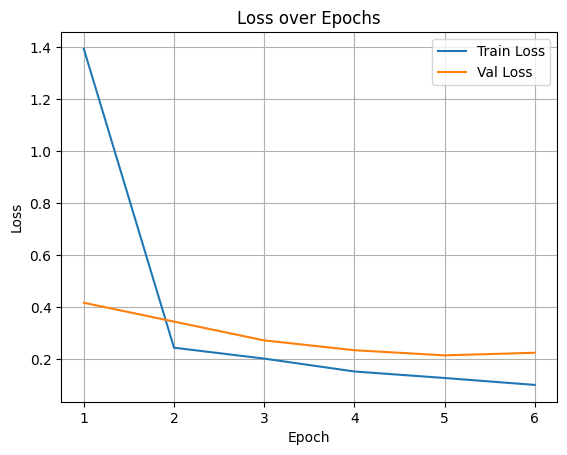

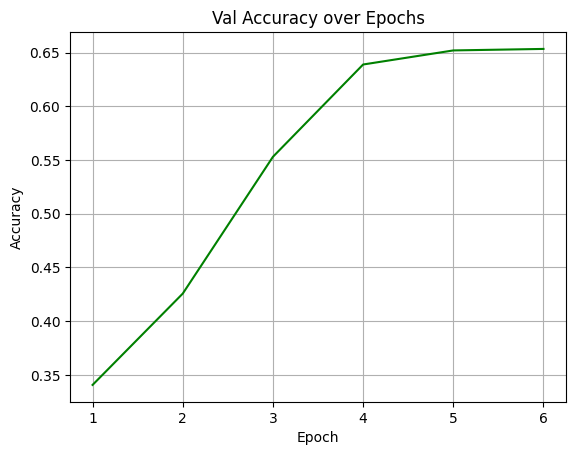

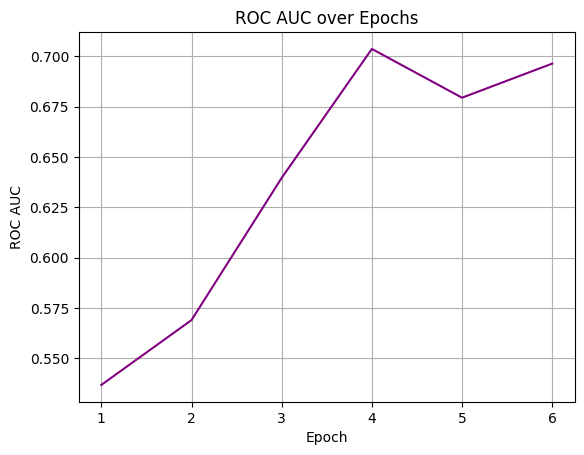

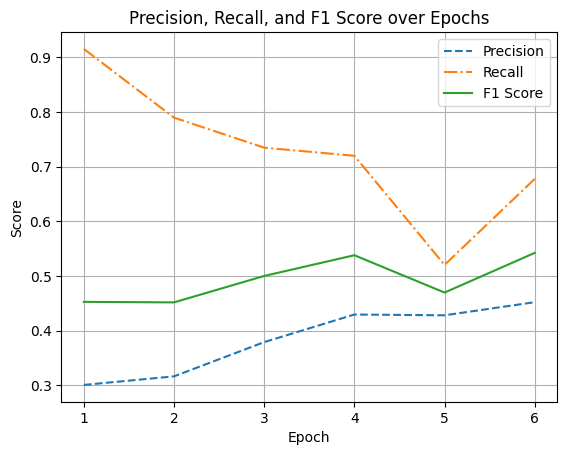

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/content/drive/MyDrive/TFM/modelos2/training_metrics_siamese12epoc_right_10000_512_def6.csv"

# Cargar el CSV
history = pd.read_csv(csv_path)

# Graficar pérdidas (losses)
plt.figure()
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Graficar exactitud (accuracy)
plt.figure()
plt.plot(history["epoch"], history["val_accuracy"], label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Val Accuracy over Epochs")
plt.grid(True)
plt.show()

# Graficar ROC AUC
plt.figure()
plt.plot(history["epoch"], history["roc_auc"], label="ROC AUC", color="purple")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.title("ROC AUC over Epochs")
plt.grid(True)
plt.show()

# Graficar Precision, Recall y F1-score
plt.figure()
plt.plot(history["epoch"], history["precision"], label="Precision", linestyle='--')
plt.plot(history["epoch"], history["recall"], label="Recall", linestyle='-.')
plt.plot(history["epoch"], history["f1_score"], label="F1 Score", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score over Epochs")
plt.legend()
plt.grid(True)
plt.show()


**CARGAR MODELO PARA HACER PRUEBAS**

In [ ]:
#CARGAMOS MODELO SI ES NECESARIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(
    "/content/drive/MyDrive/TFM/modelos2/best_siamese_contrastive_12epoc_right_10000_512_def6.pth",
    map_location=device,
    weights_only=False
)

# Cargar pesos entrenados
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

SiameseNetwork(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

**VISUALIZAR CURVA ROC**

In [ ]:
val_dataset = SiameseDataset("/content/drive/MyDrive/TFM/CAT_REDEF_20/right/val", augment=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

all_labels = []
all_distances = []

with torch.no_grad():
    for img1, img2, label in val_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        out1, out2 = model(img1, img2)
        distance = F.pairwise_distance(out1, out2)

        all_labels.extend(label.cpu().numpy())
        all_distances.extend(distance.cpu().numpy())


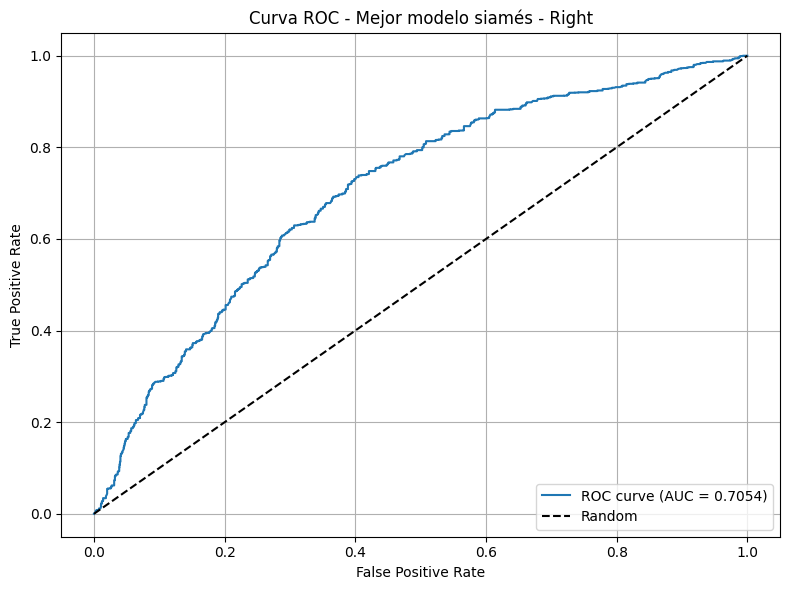

In [ ]:
from sklearn.metrics import roc_curve

# Negar las distancias si el modelo fue evaluado así
scores = [-d for d in all_distances]

fpr, tpr, thresholds = roc_curve(all_labels, scores)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(all_labels, scores):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Mejor modelo siamés - Right')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**TRANSFORMACIONES**

In [ ]:
# REDIMENSIONAR SIN DEFORMAR

from torchvision.transforms import functional as TF

class ResizeWithPadding:
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        target_h, target_w = self.size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)

        img = TF.resize(img, (new_h, new_w))

        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        pad_right = target_w - new_w - pad_left
        pad_bottom = target_h - new_h - pad_top

        img = TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img

#los bordes de las imágenes que hay que rellenar para completar el tamaño se rellenan
#con color negro

In [ ]:
resize_pad = ResizeWithPadding((224, 224)) #redimensionamos a 224x224

train_transform = transforms.Compose([
    resize_pad,
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.2, 0.8))
    ], p=0.3),  # 30% de probabilidad de aplicar el blur
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, shear=5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    resize_pad,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform = test_transform #para usar luego con las nuevas imágenes de prueba

**FUNCIÓN PARA CREAR EMBEDDINGS PROMEDIO DEL CATÁLOGO INCLUYENDO UNA IMAGEN REPRESENTATIVA DE CADA CLASE**

In [ ]:
#Incluye ruta a imagenes en el catalogo de embeddings

import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
from collections import defaultdict

def compute_average_embeddings(model, dataset_path, transform, device,
                               save_path_emb="/content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_10000_512_def_test7.pkl"):
    model.eval()
    embeddings_per_class = defaultdict(list)
    image_paths_per_class = defaultdict(list)

    # Dataset estructurado como ImageFolder
    dataset = ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Guardar también rutas originales
    original_image_paths = [path for path, _ in dataset.samples]

    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(loader, desc="Extrayendo embeddings")):
            images = images.to(device)
            embeddings = model.forward_once(images)  # Rama única de red siamesa

            for j, (emb, label) in enumerate(zip(embeddings, labels)):
                class_name = dataset.classes[label]
                index_in_dataset = i * loader.batch_size + j
                img_path = original_image_paths[index_in_dataset]

                embeddings_per_class[class_name].append(emb.cpu())
                image_paths_per_class[class_name].append(img_path)

    # Generar el diccionario final con embedding promedio con imagen representativa
    avg_catalog = {}
    for cls in embeddings_per_class:
        avg_emb = torch.stack(embeddings_per_class[cls]).mean(dim=0) #Calcula la media de los embeddings
        representative_img_path = image_paths_per_class[cls][0]  # la primera imagen de esa clase
        avg_catalog[cls] = {
            "embedding": avg_emb,
            "image_path": representative_img_path
        }

    # Guardar como pickle
    with open(save_path_emb, 'wb') as f:
        pickle.dump(avg_catalog, f)

    print(f"\n✅ Catálogo de embeddings promedio guardado en: {save_path_emb}")
    return avg_catalog


**CREACIÓN Y ALMACENAMIENTO EMBEDDINGS DEL CATÁLOGO**




In [ ]:
catalog_path = "/content/drive/MyDrive/TFM/CAT_EMB_1_TEST/left"

avg_embeddings = compute_average_embeddings(
    model=model,
    dataset_path=catalog_path,
    transform=transform,  # usa transform que incluye ResizeWithPadding
    device=device,
    save_path_emb="/content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_10000_512_def_test7.pkl"
)


Extrayendo embeddings: 100%|██████████| 1/1 [00:12<00:00, 12.27s/it]


✅ Catálogo de embeddings promedio guardado en: /content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_10000_512_def_test7.pkl


**VISUALIZAR EMBEDDINGS DEL CATÁLOGO**

In [ ]:
import pickle

# Ruta al archivo con embeddings promedio
emb_path = "/content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_10000_512_def_test7.pkl"

with open(emb_path, "rb") as f:
    avg_embeddings = pickle.load(f)

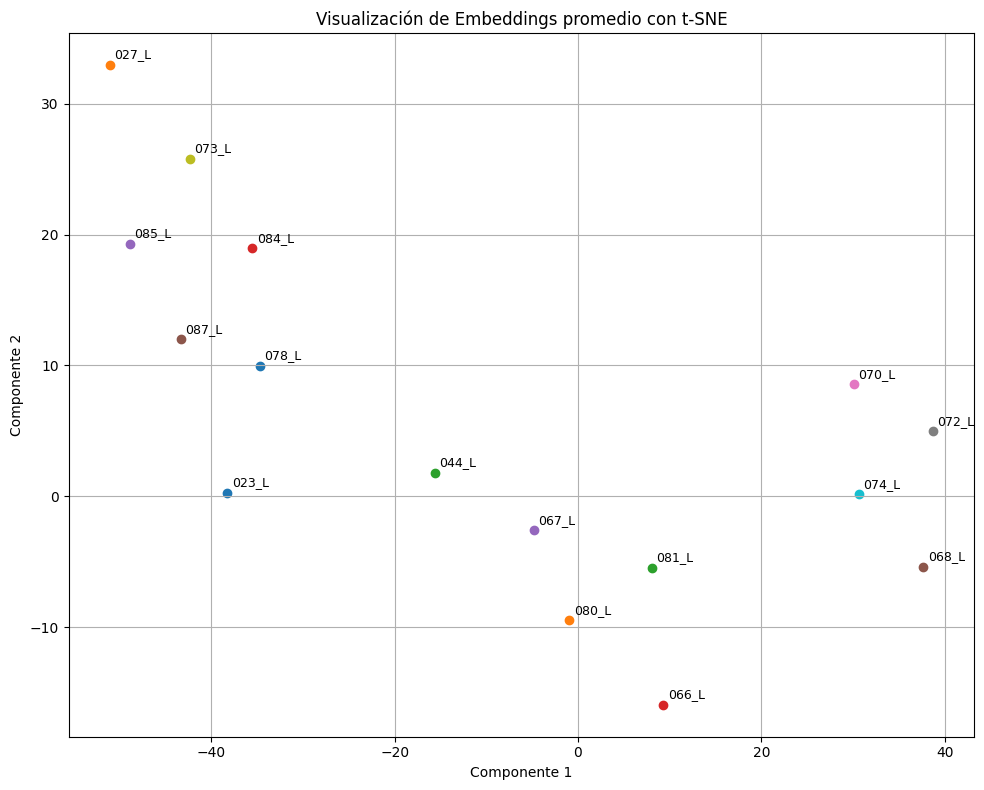

In [ ]:

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extraer etiquetas y embeddings desde el diccionario
labels = list(avg_embeddings.keys())
embeddings = np.stack([
    avg_embeddings[label]["embedding"].cpu().numpy()
    for label in labels
])

# Aplicar t-SNE (t-distributed Stochastic Neighbor Embedding - reduce la dimensionalidad
#de los embeddings para poder visualizarlos en 2D)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualizar
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.5, y + 0.5, label, fontsize=9)

plt.title("Visualización de Embeddings promedio con t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.tight_layout()
plt.show()


**VISUALIZAR TODOS EMBEDDINGS DEL CONJUNTO TEST**

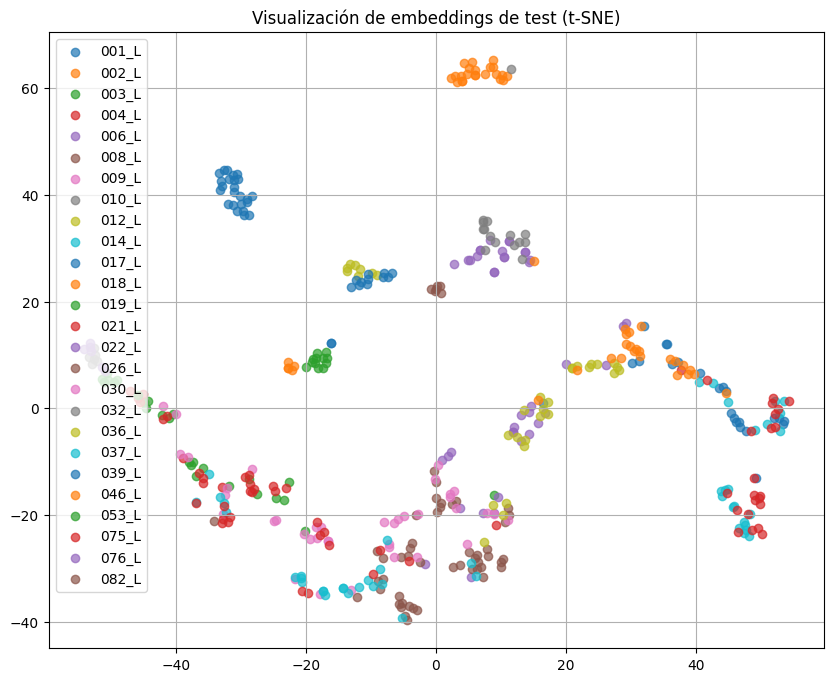

In [ ]:
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from collections import defaultdict

# Asegúrate de tener la clase ResizeWithPadding definida
class ResizeWithPadding:
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        target_h, target_w = self.size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)

        img = transforms.functional.resize(img, (new_h, new_w))

        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        pad_right = target_w - new_w - pad_left
        pad_bottom = target_h - new_h - pad_top

        img = transforms.functional.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img

# Transformación para test
resize_pad = ResizeWithPadding((224, 224))
test_transform = transforms.Compose([
    resize_pad,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Cargar dataset
test_dir = "/content/drive/MyDrive/TFM/CAT_DEF_20/left/train"
dataset = ImageFolder(root=test_dir, transform=test_transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Extraer embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        embeddings = model.forward_once(images)
        all_embeddings.append(embeddings.cpu())
        all_labels.extend(labels.cpu().numpy())

all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
all_labels = np.array(all_labels)
label_names = [dataset.classes[i] for i in all_labels]

# t-SNE
tsne = TSNE(n_components=2, perplexity=min(10, len(all_embeddings)-1), random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Visualización
plt.figure(figsize=(10, 8))
for label in np.unique(all_labels):
    idx = all_labels == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=dataset.classes[label], alpha=0.7)

plt.legend()
plt.title("Visualización de embeddings de test (t-SNE)")
plt.grid(True)
plt.show()


**USO ALGORTIMO IDENTIFICACIÓN NUEVA IMAGEN USANDO ALGORITMO KNN**


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from sklearn.neighbors import NearestNeighbors
import os

#Función creación de embeddings

def get_embedding(model, image_path, transform, device, use_cosine=False):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        embedding = model.forward_once(img_tensor).squeeze(0)
        embedding = F.normalize(embedding, p=2, dim=0) if use_cosine else embedding

    return embedding.cpu().numpy()

#Función predicción usando k-nearest neighbours

def predict_with_dynamic_knn(image_path, model, transform, catalog_pkl_path, device, k=5, metric='euclidean'):
    # Cargar catálogo
    with open(catalog_pkl_path, "rb") as f:
        catalog = pickle.load(f)

    class_ids = list(catalog.keys())
    embeddings = np.stack([catalog[c]['embedding'].numpy() for c in class_ids])
    image_paths_dict = {c: catalog[c]['image_path'] for c in class_ids}

    # Obtener embedding de la imagen incógnita
    query_embedding = get_embedding(model, image_path, transform, device, use_cosine=(metric == 'cosine')).reshape(1, -1)

    # Construir índice k-NN y buscar
    knn = NearestNeighbors(n_neighbors=k, metric=metric)
    knn.fit(embeddings)
    distances, indices = knn.kneighbors(query_embedding)

    neighbors = [class_ids[i] for i in indices[0]]

    # Mostrar resultados
    print(f"\nTop-{k} predicciones para: {os.path.basename(image_path)}")
    for i, (name, dist) in enumerate(zip(neighbors, distances[0]), 1):
        print(f"{i}. {name} (distancia: {dist:.4f})")

    # Visualización
    fig, axs = plt.subplots(1, k + 1, figsize=(3 * (k + 1), 4))
    query_img = Image.open(image_path).convert('RGB')
    axs[0].imshow(query_img)
    axs[0].axis("off")
    axs[0].set_title("Consulta")

    for i, name in enumerate(neighbors, 1):
        img_path = image_paths_dict.get(name)
        if img_path and os.path.exists(img_path):
            match_img = Image.open(img_path).convert("RGB")
            axs[i].imshow(match_img)
            axs[i].axis("off")
            axs[i].set_title(f"{i}. {name}\nDist: {distances[0][i-1]:.4f}")
        else:
            axs[i].text(0.5, 0.5, "No img", ha='center', va='center')
            axs[i].axis("off")

    plt.tight_layout()
    plt.show()

    return neighbors, distances[0]


**FUNCIÓN PARA CALCULAR PRECISIÓN TOP 1, TOP 3 Y TOP 5**

In [ ]:
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F
from PIL import Image
import os
import pickle
import numpy as np

def get_embedding(model, image_path, transform, device, use_cosine=False):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        embedding = model.forward_once(img_tensor).squeeze(0)
        embedding = F.normalize(embedding, p=2, dim=0) if use_cosine else embedding

    return embedding.cpu().numpy()

def calculate_topk_accuracy_siamese_knn(model, test_folder, catalog_pkl_path, transform, device, k_values=[1, 3, 5], metric='euclidean'):
    model.eval()

    # Cargar catálogo
    with open(catalog_pkl_path, 'rb') as f:
        catalog = pickle.load(f)

    class_ids = list(catalog.keys())
    embeddings = np.stack([catalog[c]['embedding'].numpy() for c in class_ids])

    # Inicializar KNN
    knn = NearestNeighbors(n_neighbors=max(k_values), metric=metric)
    knn.fit(embeddings)

    # Inicializar contadores
    correct_topk = {k: 0 for k in k_values}
    total = 0

    for individual in os.listdir(test_folder):
        individual_path = os.path.join(test_folder, individual)
        if not os.path.isdir(individual_path):
            continue

        image_files = [f for f in os.listdir(individual_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in image_files:
            img_path = os.path.join(individual_path, img_name)

            # Obtener embedding de la imagen de test
            query_emb = get_embedding(model, img_path, transform, device, use_cosine=(metric == 'cosine')).reshape(1, -1)

            # Buscar vecinos
            _, indices = knn.kneighbors(query_emb)

            # Obtener predicciones
            predicted_ids = [class_ids[i] for i in indices[0]]

            for k in k_values:
                if individual in predicted_ids[:k]:
                    correct_topk[k] += 1

            total += 1

    # Calcular precisión top-k
    accuracy_topk = {k: correct_topk[k] / total if total > 0 else 0.0 for k in k_values}
    return accuracy_topk


In [ ]:
#USO CALCULO PRECISIÓN TOP1, TOP3 Y TOP5 CON DATOS TEST

test_folder = "/content/drive/MyDrive/TFM/CAT_DEF_20/left/test"
catalog_pkl_path = "/content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_10000_512_def_test7.pkl"

accuracy_topk = calculate_topk_accuracy_siamese_knn(
    model=model,
    test_folder=test_folder,
    catalog_pkl_path=catalog_pkl_path,
    transform=transform,
    device=device,
    k_values=[1, 3, 5],
    metric='euclidean'
)

# Mostrar resultados
for k, acc in accuracy_topk.items():
    print(f"Precisión Top-{k}: {acc * 100:.2f}%")


**USO ALGORITMO CON NUEVAS IMÁGENES**


Top-3 predicciones para: orca002_2.jpg
1. 007_R (distancia: 2.7109)
2. 002_R (distancia: 2.7630)
3. 039_R (distancia: 2.7987)


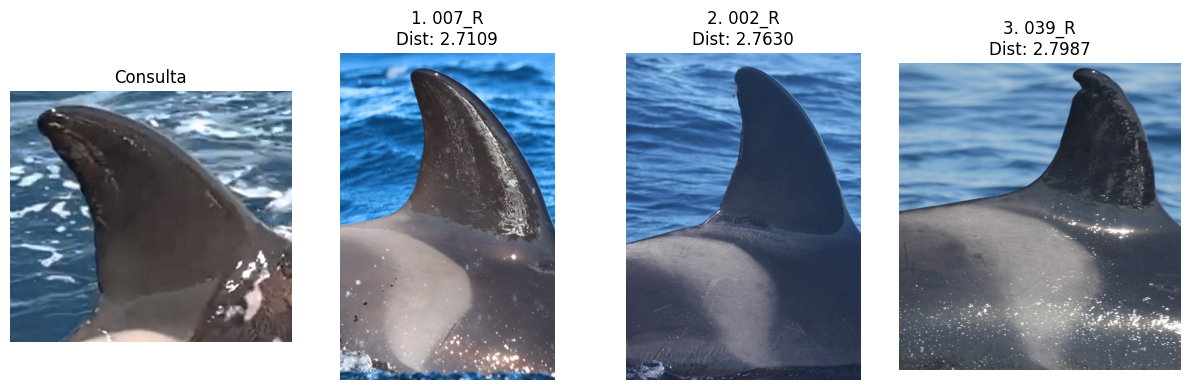

In [ ]:
# Rutas y parámetros
catalog_pkl_path = "/content/drive/MyDrive/TFM/modelos2/avg_embeddings_right_contrast_7000_512.pkl" #CATALOGO EMBEDDINGS REFERENCIA
query_image_path = "/content/drive/MyDrive/TFM/Orca/orca002_2.jpg" #Imagen de consulta

# Ejecutar predicción
neighbors, distances = predict_with_dynamic_knn(
    image_path=query_image_path,
    model=model,                  # El modelo entrenado siamesa
    transform=transform,          # Transformaciones de test
    catalog_pkl_path=catalog_pkl_path,
    device=device,
    k=3,
    metric='euclidean'      #uso distancia euclídea
)


**VISUALIZACIÓN DE TRANSFORMACIÓN PARA AUMENTACIÓN DE DATOS**

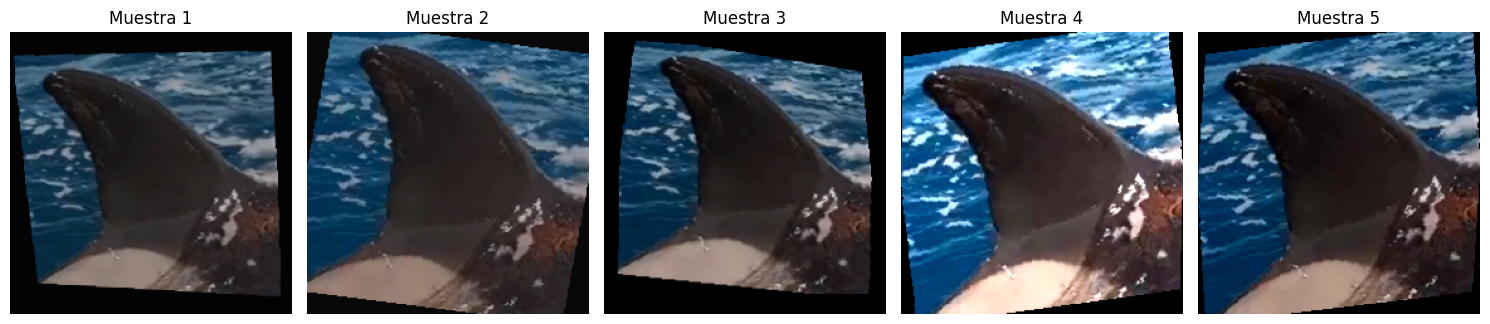

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image
import torch

# Ruta a una imagen de entrenamiento
img_path = "/content/drive/MyDrive/TFM/Orca/orca_onix.jpg"  # <- reemplázala por una imagen real de tu dataset
img = Image.open(img_path).convert("RGB")

# Repetir varias veces para ver diferentes resultados de aumento aleatorio
num_samples = 5
fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    # Aplicar transformación de entrenamiento
    transformed = train_transform(img)

    # Desnormalizar (valores a rango 0-1 para visualizar)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    transformed_vis = transformed * std + mean
    transformed_vis = torch.clamp(transformed_vis, 0, 1)

    # Convertir a numpy y mostrar
    axs[i].imshow(transformed_vis.permute(1, 2, 0).numpy())
    axs[i].axis("off")
    axs[i].set_title(f"Muestra {i+1}")

plt.tight_layout()
plt.show()
